In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# Importar datos
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
# importar la libreria para separar en train y test
from sklearn.model_selection import train_test_split

In [2]:
# Load the data from https://raw.githubusercontent.com/gziz/cei-ds/main/data/raw/aire_06_06_22.csv?token=GHSAT0AAAAAABV45OK4NME4K6KBZNPUBQ6IYV6G63A
data_raw = pd.read_csv('DataJuarez/aire_06_06_22.csv')
input_CSV = ['CO','NO2','PM10','PM25','SO2','O3']
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
def clean_data(data):
    # Eliminar la columan llamada 'Unnamed: 0'
    data = data.drop(['Unnamed: 0'], axis=1)
    # Eliminar las columnas que sean solo NaN
    for col in input_CSV:
        data.drop(data[data[col] <= 0].index, inplace=True)
    return data

In [4]:
data = clean_data(data_raw)
# agarrar solo los datos de la Sensor_id S6 y S7
data_S6 = data[data['Sensor_id'].isin(['ANL4'])]
# order by sensor_id
data_S6 = data_S6.sort_values(by=['Sensor_id'])
#borrar las filas que no tengan O3
data_S6 = data_S6[data_S6['O3'] > 0]
#borrar las filas que no tengan PM10
data_S6 = data_S6[data_S6['PM10'] > 0]
#borrar las filas que no tengan PM25
data_S6 = data_S6[data_S6['PM25'] > 0]
#borrar las filas que no tengan SO2
data_S6 = data_S6[data_S6['SO2'] > 0]
#borrar las filas que no tengan NO2
data_S6 = data_S6[data_S6['NO2'] > 0]
# quitar la columna de Dia
data_S6 = data_S6.drop(['Dia'], axis=1)
# quitar la columna de Registros_id
data_S6 = data_S6.drop(['Registros_id'], axis=1)
# quitar Sensor_id
data_S6 = data_S6.drop(['Sensor_id'], axis=1)
# quitar HUMEDAD
#data_S6 = data_S6.drop(['HUMEDAD'], axis=1)
# quitar TEMPERATURA
#data_S6 = data_S6.drop(['TEMPERATURA'], axis=1)
# convertir nans en 0
data_S6 = data_S6.fillna(0)
# convertir los datos a numpy
data_S6_numpy = data_S6.to_numpy()

In [54]:
# Hacer los valores de salida y entrada
# El valor respuesta es el siguiente dato
X_data = data_S6_numpy[:-1,:]
y_data = data_S6_numpy[1:,:]
# estandarizar los datos
#"""
X_data = (X_data - X_data.mean(axis=0)) / X_data.std(axis=0)
y_data = (y_data - y_data.mean(axis=0)) / y_data.std(axis=0)
#"""
# separar los datos en train y test
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, shuffle=False)
# convertir los datos a tensor
X_train = torch.from_numpy(X_train).float().to(device)
X_test = torch.from_numpy(X_test).float().to(device)
y_train = torch.from_numpy(y_train).float().to(device)
y_test = torch.from_numpy(y_test).float().to(device)

In [55]:
# O3 forecasting
class O3Forecasting(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(O3Forecasting, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        # output size is the same as the input size
        self.linear = nn.Linear(hidden_size, input_size)
    def forward(self, x, future=0):
        # outputs
        outputs = []
        n_sample = x.size(0)
        # get the initial hidden state of the LSTM
        h_t1 = torch.zeros(1, self.hidden_size).to(device)
        c_t1 = torch.zeros(1, self.hidden_size).to(device)
        h_t2 = torch.zeros(1, self.hidden_size).to(device)
        c_t2 = torch.zeros(1, self.hidden_size).to(device)

        for input_t in x.split(1,dim=0):
            # input_t is a vector of size input_size
            # h_t is a vector of size hidden_size
            # c_t is a vector of size hidden_size
            # output_t is a vector of size hidden_size
            # h_t, c_t = self.lstm(input_t, (h_t, c_t))
            #print(input_t.shape)
            out, (h_t1, c_t1) = self.lstm1(input_t, (h_t1, c_t1))
            out, (h_t2, c_t2) = self.lstm2(out, (h_t2, c_t2))
            output_t = self.linear(F.gelu(h_t2))
            #print (output_t.shape)
            outputs.append(output_t)
        
        for i in range(future):
            #print (output_t.shape)
            out,(h_t1, c_t1) = self.lstm1(output_t, (h_t1, c_t1))
            out,(h_t2, c_t2) = self.lstm2(out, (h_t2, c_t2))
            output_t = self.linear(F.gelu(h_t2))
            outputs.append(output_t)
        
        outputs = torch.cat(outputs, dim=0)
        return outputs

In [56]:
print (X_train.shape)

torch.Size([13228, 8])


In [57]:
# Test the model input
input_size = X_train.size(1)
print (input_size)
print (X_train.shape)
Model = O3Forecasting(input_size=input_size, hidden_size=32)
Model.to(device)
output_test = Model(X_test[:10], future = 100)

8
torch.Size([13228, 8])


In [58]:
print (output_test.shape)

torch.Size([110, 8])


In [59]:
def plot_function(future = 10):
    with torch.no_grad():
        y_pred = Model(X_test[:future], future=future)
        y_pred_print = y_pred.cpu().detach().numpy()[:,0]
        y_test_print = y_test.cpu().detach().numpy()[:,0]
    # visualizar el modelo 
    #plt.plot(y_test_print[:future], label='Real')
    #plt.plot(y_pred_print[future:future*2], label='Predicted')
    plt.plot(np.arange(future*2), y_test_print[:future*2], label='Real')
    plt.plot(np.arange(future-50,future*2), y_pred_print[future-50:future*2], label='Predicted')
    ## añadir una linea vertical
    plt.axvline(x=future, color='r', linestyle='--', label='Future')
    plt.legend()
    plt.show()

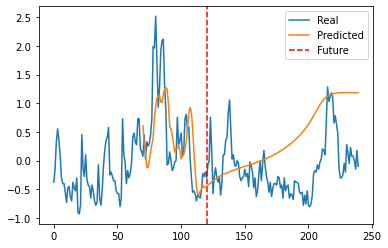

Epoch:  0  Loss:  0.5026690363883972


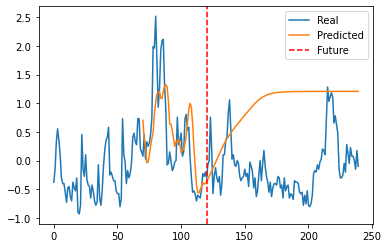

Epoch:  1  Loss:  0.491203635931015


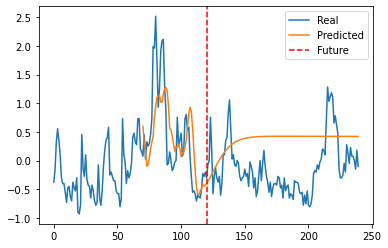

Epoch:  2  Loss:  0.5320013761520386


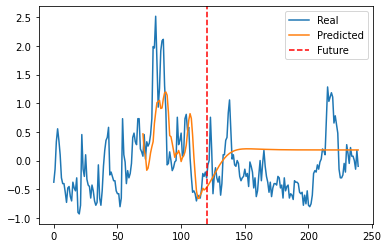

Epoch:  3  Loss:  0.47190701961517334


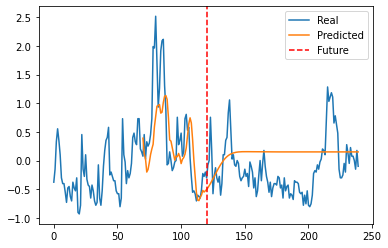

Epoch:  4  Loss:  0.460700660943985


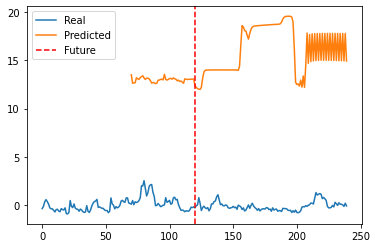

Epoch:  5  Loss:  0.4584507644176483


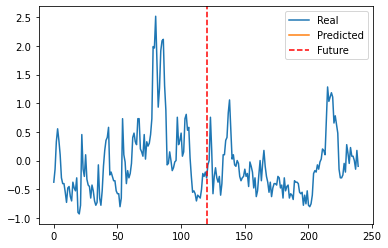

Epoch:  6  Loss:  88.8314437866211


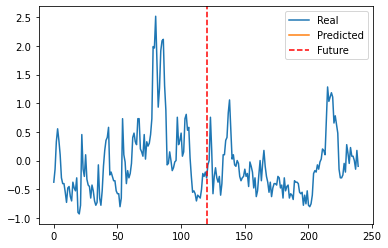

Epoch:  7  Loss:  nan


KeyboardInterrupt: 

In [64]:
criterion = nn.MSELoss()
optimizer = torch.optim.LBFGS(Model.parameters(), lr=0.4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.8)
epochs = 100
#clip = 5
for i in range(epochs):
    def closure():
        optimizer.zero_grad()
        output = Model(X_train[:300], future=200)
        loss = criterion(output, y_train[:500])
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(Model.parameters(), clip)
        return loss
    loss = optimizer.step(closure)
    if i % 1 == 0:
        plot_function(future = 120)
        print('Epoch: ', i, ' Loss: ', loss.item())
        scheduler.step()

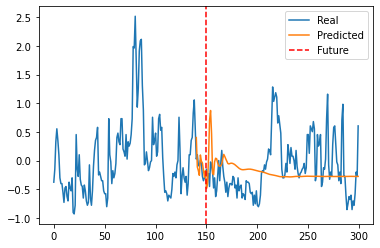

In [20]:
def plot_function(future = 10):
    with torch.no_grad():
        y_pred = Model(X_test[:future], future=future)
        y_pred_print = y_pred.cpu().detach().numpy()[:,0]
        y_test_print = y_test.cpu().detach().numpy()[:,0]
    # visualizar el modelo 
    #plt.plot(y_test_print[:future], label='Real')
    #plt.plot(y_pred_print[future:future*2], label='Predicted')
    plt.plot(np.arange(future*2), y_test_print[:future*2], label='Real')
    plt.plot(np.arange(future-10,future*2), y_pred_print[future-10:future*2], label='Predicted')
    ## añadir una linea vertical
    plt.axvline(x=future, color='r', linestyle='--', label='Future')
    plt.legend()
    plt.show()
plot_function(future=150)